# Hierarchical Compartmental Reserving Models for Business Planning

In [1]:
library(data.table)
dev_n <- 48
ay_start <- 2024
ay_end <- 2027
ay_n <- ay_end - ay_start + 1

CycleIndex <- data.table(
    accident_year = (ay_start:ay_end),
    RateIndex = c(1, 1.1, 1.05, 0.95)
)

In [2]:
library(brms)
claims_dynamics <- "
// ODE system 
vector compartmentmodel(real t, vector y, vector theta) {
  vector[3] dydt;
  // Define ODEs
  dydt[1] = - theta[1] * y[1];                            // exposure 
  dydt[2] = theta[1] * theta[3] * y[1] - theta[2] * y[2]; // outstanding
  dydt[3] = theta[2] * theta[4] * y[2];                   // paid
 
  return dydt;
  }

real incrclaimsprocess(real t, real devfreq, real ker, real kp, 
                       real RLR, real RRF, real delta){
    vector[3] y0;
    array[1] vector[3] y;
    vector[4] theta;
    theta[1] = ker; theta[2] = kp;
    theta[3] = RLR; theta[4] = RRF;
    real out; 
    // Set initial values
    y0[1] = 1; // Exposure
    y0[2] = 0; // Outstanding
    y0[3] = 0; // Paid
    
    y = ode_rk45(compartmentmodel, y0, 0, rep_array(t, 1), theta);
    out = y[1, 2] * (1 - delta) + y[1, 3] * delta;
    
    if( (delta > 0) && (t > devfreq) ){ // paid greater dev period 1
    // incremental paid
     y = ode_rk45(compartmentmodel, y0, 0, 
                  rep_array(t - devfreq, 1), theta);
     out = out - y[1, 3];
    }
    return(out);
}
"

Loading required package: Rcpp



Loading 'brms' package (version 2.22.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').


Attaching package: 'brms'


The following object is masked from 'package:stats':

    ar




In [3]:
frml <- bf(loss_ratio ~ log(eta),
            nlf(eta ~ incrclaimsprocess(dev, 1.0, ker, kp,
                                        RLR, RRF, delta)),
            nlf(ker ~ 0.1 * exp(oker * 0.05)),
            nlf(kp ~ 0.5 * exp(okp * 0.025)),
            nlf(RLR ~ 0.55 * exp(oRLR * 0.025) / RateIndex),
            nlf(RRF ~ exp(oRRF * 0.05)),
            oRLR ~ 1 + (1 | ID | accident_year),
            oRRF ~ 1 + (1 | ID | accident_year),
            oker ~ 1, 
            okp ~ 1,
            sigma ~ 0 + deltaf, nl = TRUE)

In [4]:
mypriors <- c(prior(normal(0, 1), nlpar = "oRLR"),
                prior(normal(0, 1), nlpar = "oRRF"),
                prior(normal(0, 1), nlpar = "oker"),
                prior(normal(0, 1), nlpar = "okp"),
                prior(normal(log(0.1), 0.05), class = "b", 
                        coef="deltafPaid", dpar= "sigma"),
                prior(normal(log(0.05), 0.02), class = "b", 
                        coef="deltafOutstanding", dpar= "sigma"),
                prior(student_t(10, 0, 0.05), class = "sd", nlpar = "oRLR"),
                prior(student_t(10, 0, 0.05), class = "sd", nlpar = "oRRF"),
                prior(lkj(1), class="cor"))

## Prior predictive simulations

In [5]:
DT1 <- data.table(
    accident_year = rep(ay_start:(ay_start + ay_n - 1), 
                        each = dev_n),
    dev = rep(1 : dev_n, ay_n),
    loss_ratio = 1
)
DT2 <- rbindlist(list(
    data.table(DT1, delta = 0, deltaf = "Outstanding"),
    data.table(DT1, delta = 1, deltaf = "Paid")
))
# Add rate index information
setkey(DT2, accident_year)
setkey(CycleIndex, accident_year)
myDT <- CycleIndex[DT2]

In [6]:
library(cmdstanr)
set_cmdstan_path("C:/Users/alexf/OneDrive/Documents/Projects/Stan/cmdstan")

This is cmdstanr version 0.8.0

- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr

- Use set_cmdstan_path() to set the path to CmdStan

- Use install_cmdstan() to install CmdStan

CmdStan path set to: C:/Users/alexf/OneDrive/Documents/Projects/Stan/cmdstan



In [7]:
nSims <- 1000
nChains <- 4
prior_model <- brm(
    frml, prior = mypriors, data = myDT, 
    family = brmsfamily("lognormal", link_sigma = "log"),
    stanvars = stanvar(scode = claims_dynamics, 
                        block = "functions"),
    backend = "cmdstan",
    sample_prior = "only", seed = 123, 
    iter = nSims, chains = nChains)

In file included from stan/src/stan/model/model_header.hpp:5:
stan/src/stan/model/model_base_crtp.hpp:205:8: warning: 'void stan::model::model_base_crtp<M>::write_array(stan::rng_t&, std::vector<double>&, std::vector<int>&, std::vector<double>&, bool, bool, std::ostream*) const [with M = model_4f5c5ba365056a6670185ec5e4c8a93b_model_namespace::model_4f5c5ba365056a6670185ec5e4c8a93b_model; stan::rng_t = boost::random::mixmax_engine<17, 36, 0>; std::ostream = std::basic_ostream<char>]' was hidden [-Woverloaded-virtual=]
  205 |   void write_array(stan::rng_t& rng, std::vector<double>& theta,
      |        ^~~~~~~~~~~


C:/Users/alexf/AppData/Local/Temp/RtmpMT712n/model-11d04a6a16c0.hpp:2085: note:   by 'model_4f5c5ba365056a6670185ec5e4c8a93b_model_namespace::model_4f5c5ba365056a6670185ec5e4c8a93b_model::write_array'
 2085 |   write_array(RNG& base_rng, std::vector<double>& params_r, std::vector<int>&
stan/src/stan/model/model_base_crtp.hpp:136:8: warning: 'void stan::model::model_base_cr

Running MCMC with 4 sequential chains...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 1.4 seconds.
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 501 / 1000 [ 50%]  (Sampling)

Loading required namespace: rstan



In [8]:
# Expose Stan functions from the model to R
expose_functions(prior_model, vectorize = TRUE)
N <- ndraws(prior_model)
# Draw samples from the prior predictive 
prior_pred <- predict(prior_model, ndraws = N, summary = FALSE)

- `ggfan` is no longer supported, so it's not available in the current version of R (4.5)
- Implemented the fan charts using `ggdist` instead

In [9]:
SimDT <- data.table(
    accident_year = rep(myDT$accident_year, N),
    dev = rep(myDT$dev, N),
    deltaf = rep(myDT$deltaf, N),
    Sim =  as.vector(t(prior_pred)),
    SimID = rep(1:N, each = dim(prior_pred)[2])
)
SimDT[, `Sim ID` := factor(SimID)]


Attaching package: 'ggdist'


The following objects are masked from 'package:brms':

    dstudent_t, pstudent_t, qstudent_t, rstudent_t




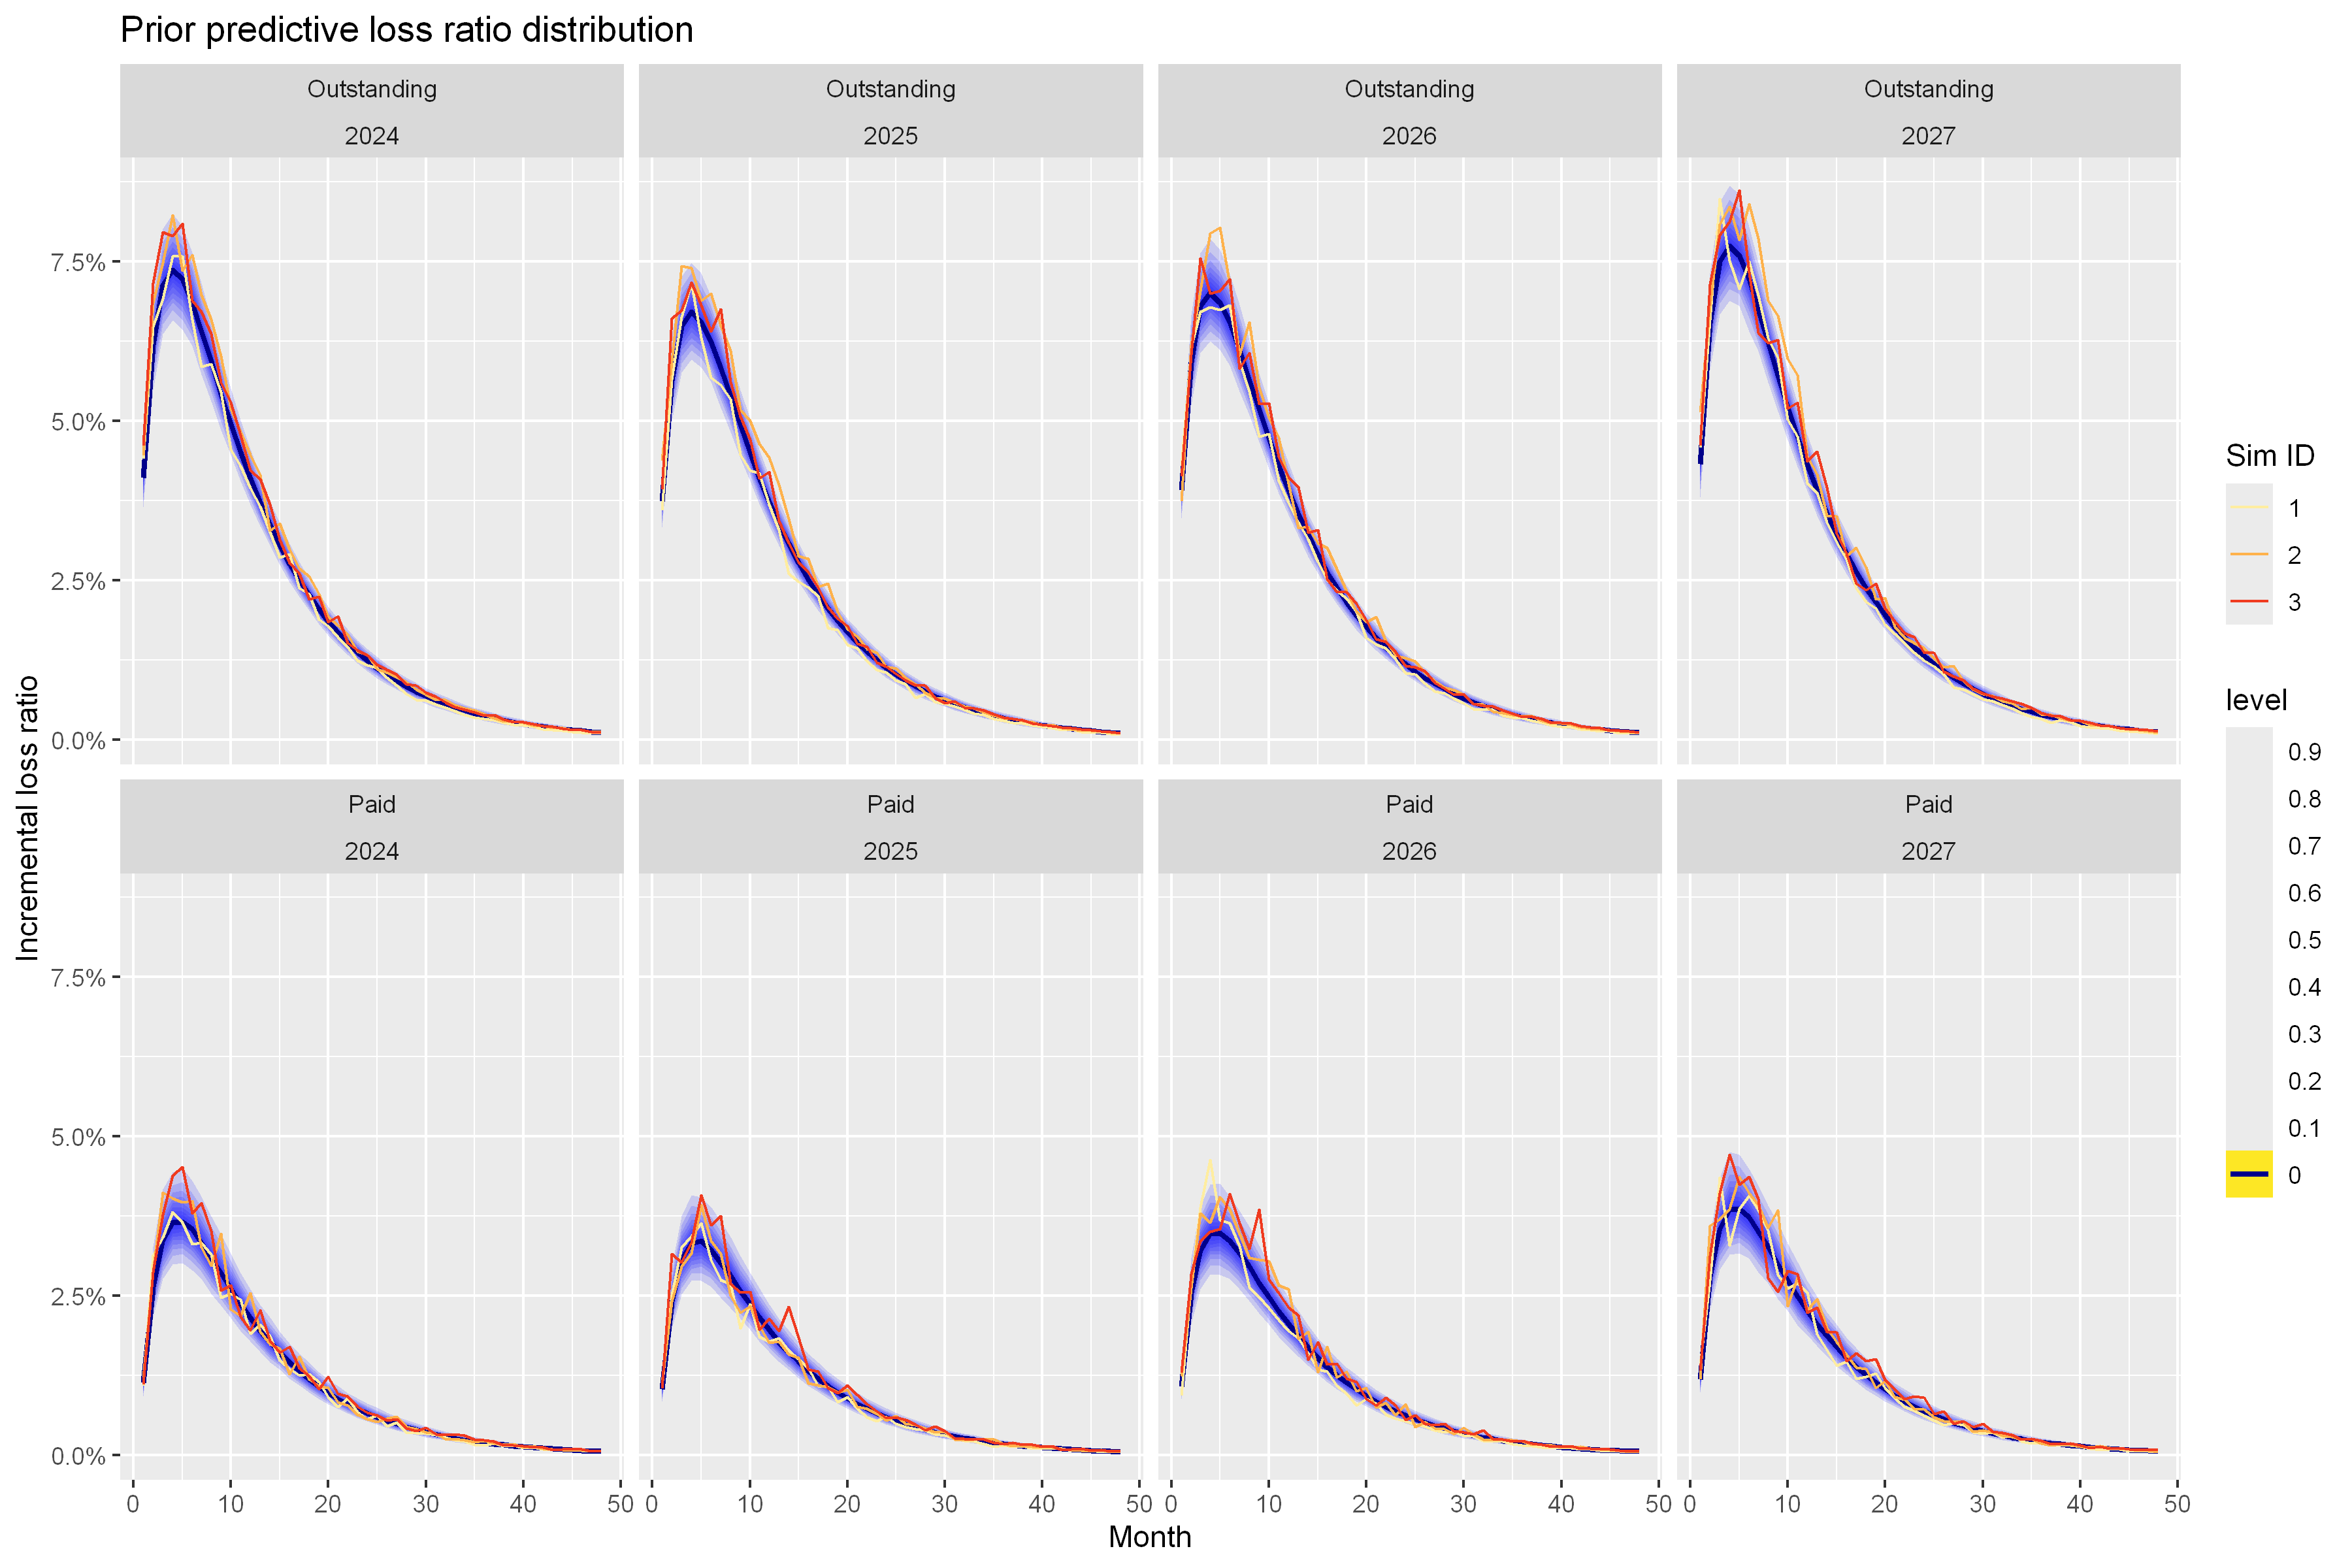

In [10]:
library(repr)
library(ggdist)
library(ggplot2)

# Alternative with more quantiles to match ggfan's default behavior
p1 <- ggplot(SimDT, aes(x = dev, y = Sim)) +
    stat_lineribbon(
        .width = c(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9),  # Multiple quantiles
        alpha = 0.15,  # Lower alpha since we have more ribbons
        fill = "blue",
        color = NA  # Remove ribbon borders for cleaner look
    ) +
    stat_lineribbon(
        .width = 0,  # Median line only
        color = "darkblue",
        size = 1
    ) +
    geom_line(data = SimDT[SimID < 4], aes(col = `Sim ID`)) +
    facet_wrap(. ~ deltaf + accident_year, ncol = ay_n) + 
    scale_color_brewer(palette = "YlOrRd") +
    scale_y_continuous(labels = scales::percent) +
    labs(x = "Month", y = "Incremental loss ratio",
        title = "Prior predictive loss ratio distribution") + 
    theme_grey()

# Set options for all subsequent plots
options(repr.plot.width = 12, repr.plot.height = 8, repr.plot.res = 300)
p1

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


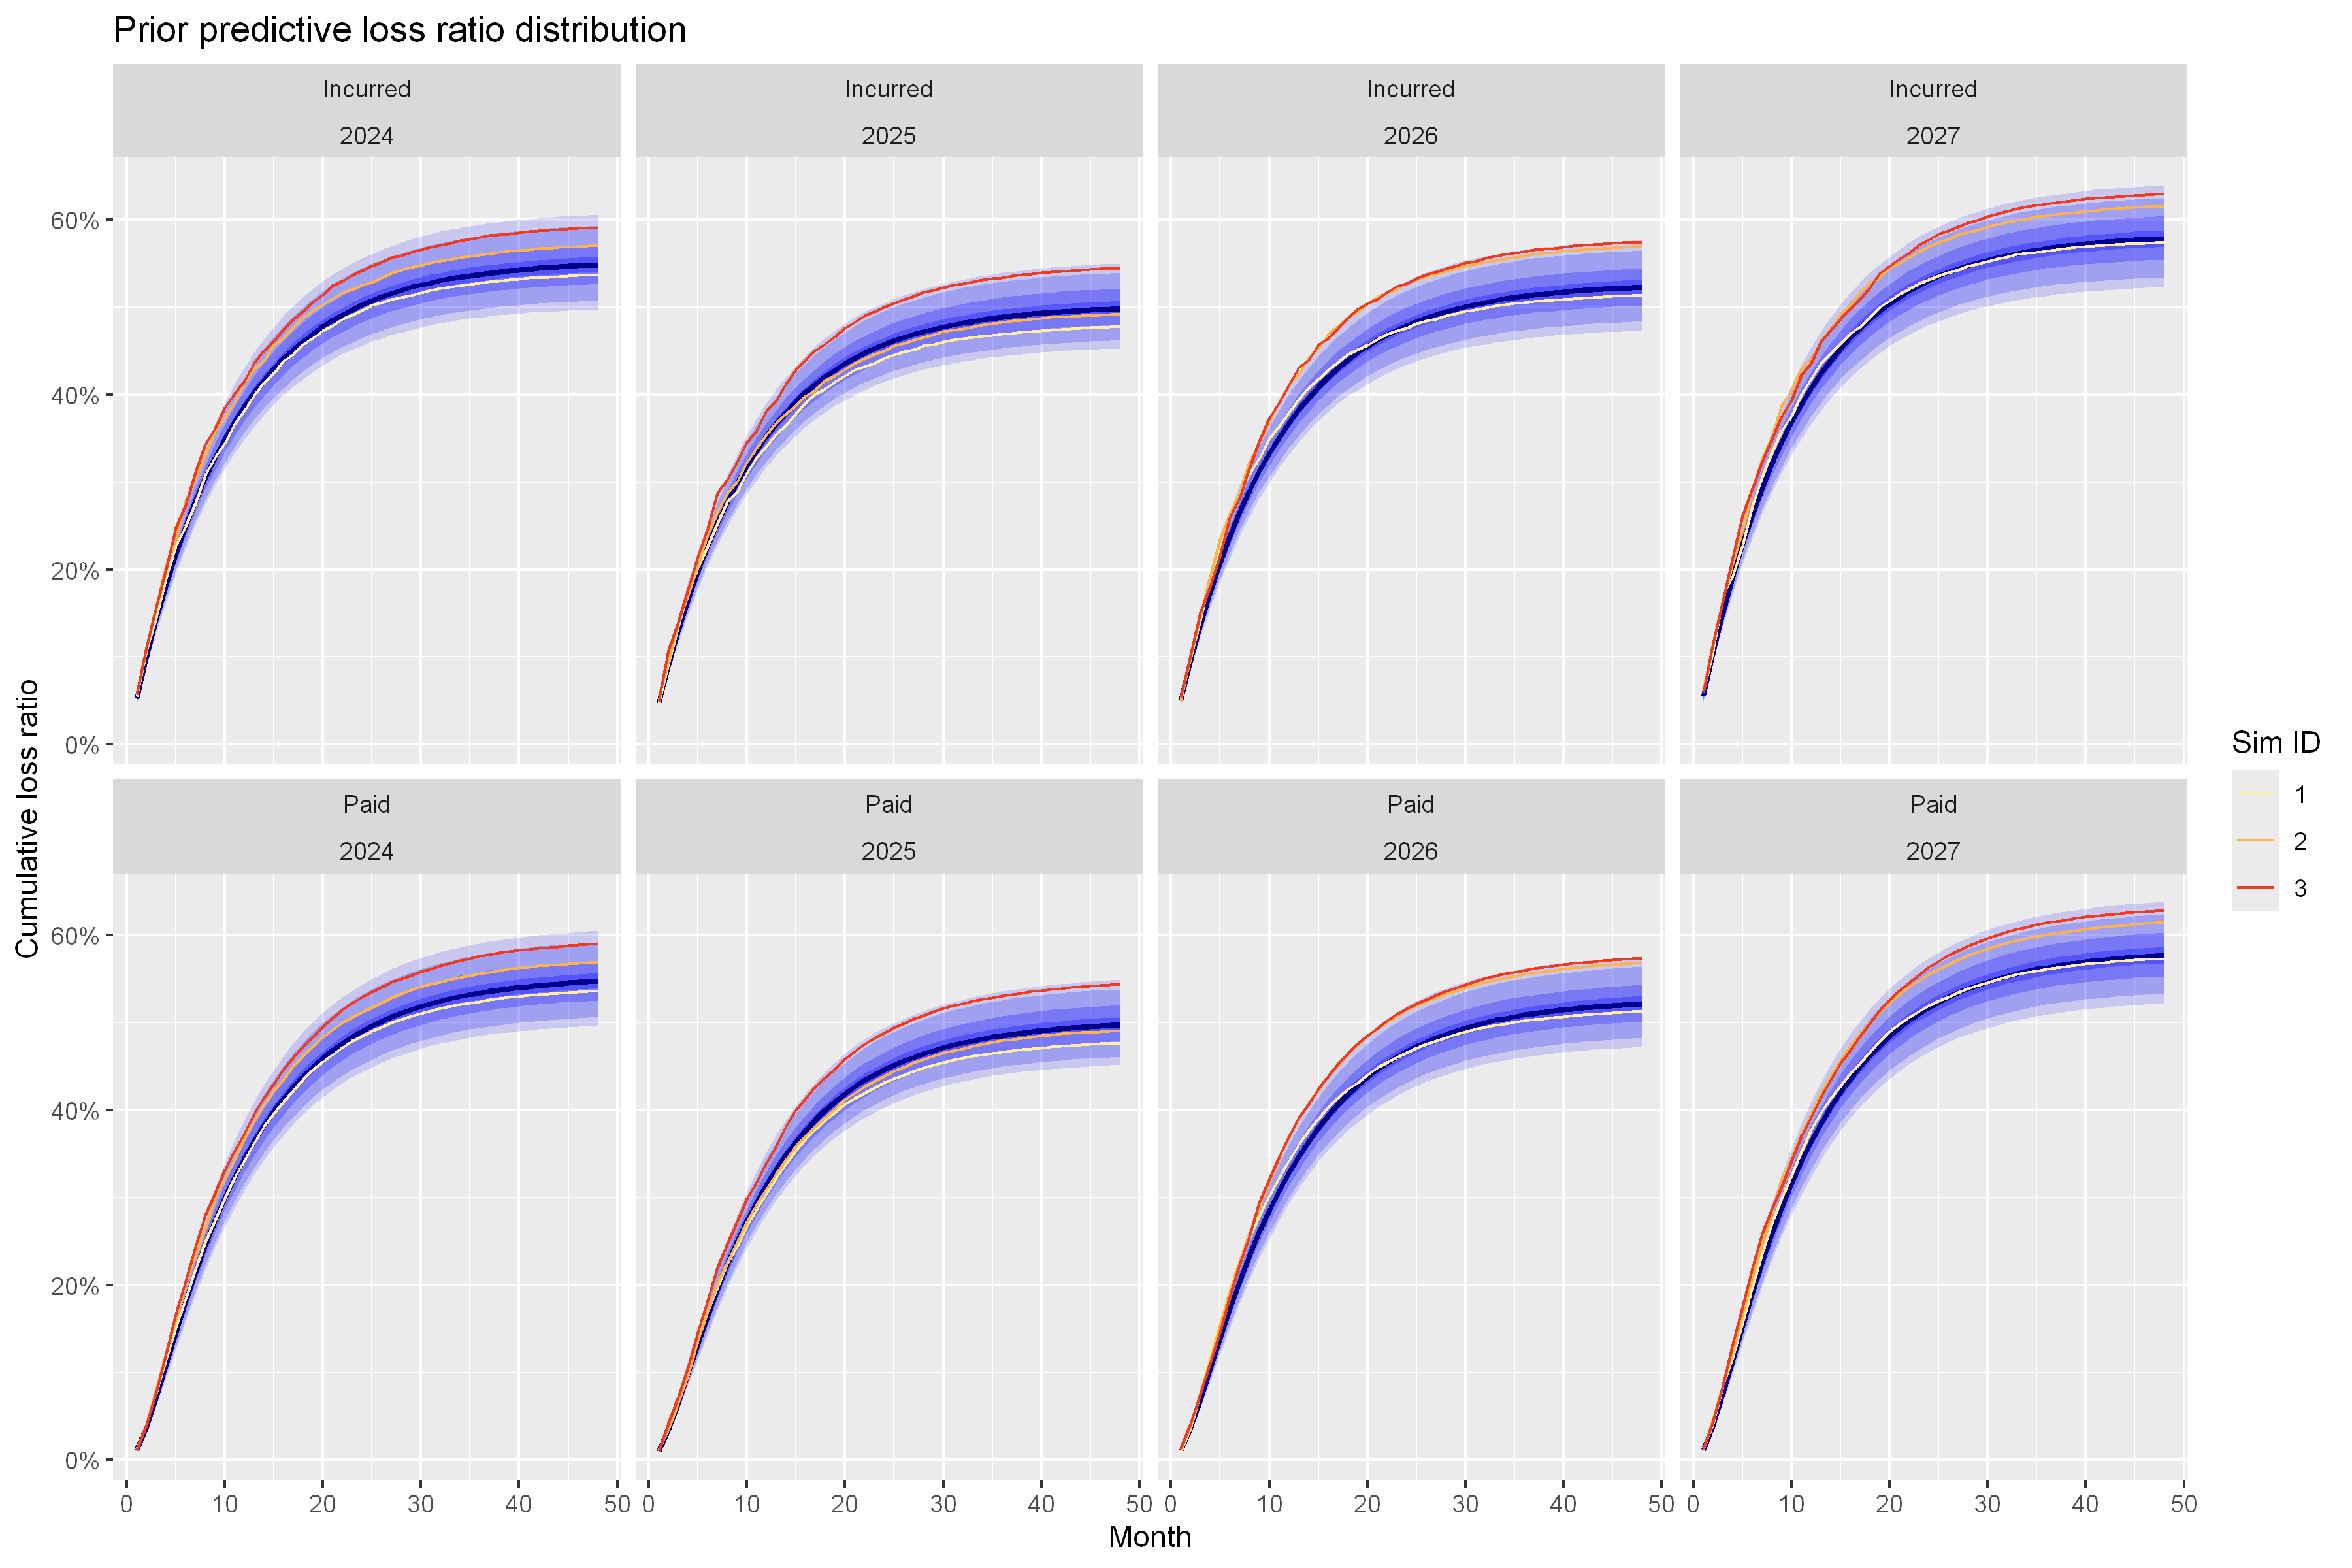

In [11]:
SimDT[deltaf %in% "Paid" , CumSim := cumsum(Sim), 
        by = list(accident_year, SimID)]
SimDT[deltaf %in% "Outstanding" , CumSim := Sim]
SimDT[, Incurred := sum(CumSim), by = .(
    accident_year, SimID, dev
)]
SimDT[deltaf %in% "Outstanding" , CumSim := Incurred]
SimDT[, Incurred := NULL]
SimDT[, deltaf2 := ifelse(deltaf %in% "Paid", "Paid", "Incurred")]

SimDT_quantiles <- SimDT[, .(
    q05 = quantile(CumSim, 0.05),
    q10 = quantile(CumSim, 0.10),
    q25 = quantile(CumSim, 0.25),
    q40 = quantile(CumSim, 0.40),
    q60 = quantile(CumSim, 0.60),
    q75 = quantile(CumSim, 0.75),
    q90 = quantile(CumSim, 0.90),
    q95 = quantile(CumSim, 0.95),
    median = median(CumSim)
), by = .(dev, deltaf2, accident_year)]

# Create the plot with multiple ribbons
p2 <- ggplot(SimDT_quantiles, aes(x = dev)) +
    # Outermost ribbon (90% interval)
    geom_ribbon(aes(ymin = q05, ymax = q95), fill = "blue", alpha = 0.15) +
    # 80% interval
    geom_ribbon(aes(ymin = q10, ymax = q90), fill = "blue", alpha = 0.20) +
    # 50% interval
    geom_ribbon(aes(ymin = q25, ymax = q75), fill = "blue", alpha = 0.25) +
    # 20% interval
    geom_ribbon(aes(ymin = q40, ymax = q60), fill = "blue", alpha = 0.30) +
    # Median line
    geom_line(aes(y = median), color = "darkblue", size = 1) +
    # Add individual simulation lines
    geom_line(data = SimDT[SimID < 4], aes(y = CumSim, col = `Sim ID`)) +
    facet_wrap(. ~ deltaf2 + accident_year, ncol = ay_n) + 
    scale_color_brewer(palette = "YlOrRd") +
    scale_y_continuous(labels = scales::percent) +
    labs(x = "Month", y = "Cumulative loss ratio",
        title = "Prior predictive loss ratio distribution") + 
    theme_grey()

p2